In [1]:
from models.Unet import UNet
from dataset.data import BatchMaker
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import (
    jaccard_score,
    average_precision_score
)


In [2]:
BATCH = 1
path_to_config = '/media/marcin/Dysk lokalny/Programowanie/Python/Magisterka/Praca Dyplomowa/noisy_labels/Kod/config/config.yaml'
#path_to_config = '/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Kod/config/config_lab.yaml'
with open(path_to_config, 'r') as config_file:
    config = yaml.safe_load(config_file)
model_path = config['save_model_path'] + '/mixedGT1_best_model'


annotator1 = BatchMaker(config_path=path_to_config, batch_size=BATCH, mode = 'all',segment = 'mixed',annotator= 1)
train_GT1 = annotator1.train_loader
annotator2 = BatchMaker(config_path=path_to_config, batch_size=BATCH, mode = 'all',segment = 'mixed',annotator= 2)
train_GT2 = annotator2.train_loader


/media/marcin/Dysk lokalny/Programowanie/Python/Magisterka/Praca Dyplomowa/noisy_labels/Dataset/SegSperm/train


KeyboardInterrupt: 

In [32]:
import matplotlib.pyplot as plt 

labels1 = []
labels2 = []
for i in range(len(train_GT1.dataset)):
    labels1.append(train_GT1.dataset.__getitem__(i)[1][0])
    labels2.append(train_GT2.dataset.__getitem__(i)[1][0])



In [33]:
label1np = np.array(labels1)
label2np = np.array(labels2)

In [48]:
#IoU = jaccard_score(label1np, label2np)
classes = np.unique(np.concatenate((label1np.flatten(), label2np.flatten())))
jaccard_scores = []
#average_precision = average_precision_score(label1np.flatten(), label2np.flatten())


for cls in classes:
    true_mask = (label2np.flatten() == cls)
    pred_mask = (label1np.flatten() == cls)

    intersection = np.sum(true_mask & pred_mask)
    union = np.sum(true_mask | pred_mask)

    jaccard = intersection / union if union > 0 else 0
    jaccard_scores.append(jaccard)

# Average the Jaccard scores across all classes
average_jaccard = np.mean(jaccard_scores)

print("Jaccard scores for each class:", jaccard_scores)

#print("IoU: {}".format(IoU))
#print("Average Precision: {}".format(average_precision))    

Jaccard scores for each class: [0.9939750840052808, 0.722969509149901, 0.3689429403379839]


In [53]:
import tensorflow as tf

score = tf.keras.metrics.MeanIoU(num_classes=3)
score.update_state(label1np.flatten(), label2np.flatten())
score.result().numpy()

1.0

In [15]:
from models.Unet import UNet
from dataset.data import BatchMaker
import torch
import yaml
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import (
    jaccard_score,
    average_precision_score
)

num_classes = 3
BATCH = 1
#path_to_config = '/media/marcin/Dysk lokalny/Programowanie/Python/Magisterka/Praca Dyplomowa/noisy_labels/Kod/config/config.yaml'
#path_to_config = '/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Kod/config/config_lab.yaml'
#path_to_config = '/home/nitro/Studia/Praca Dyplomowa/noisy_labels/Kod/config/config_laptop.yaml'
with open(path_to_config, 'r') as config_file:
    config = yaml.safe_load(config_file)
model_path = config['save_model_path'] + '/mixedGT1_best_model_3'


batch_maker = BatchMaker(config_path=path_to_config, batch_size=BATCH, mode = 'test',segment = 'mixed',annotator= 1)
test_loader = batch_maker.test_loader



def plot_sample(X, y, preds, ix=None):
    """Function to plot the results"""
    colors = [[0, 0, 0], [0, 255, 0], [255, 0, 0]]  # tło, wić, główka
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3,figsize=(20, 10))
    ax[0].imshow(X[ix])
    #if has_mask:
        #ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Sperm Image')
    ax[0].set_axis_off()


    mask_to_display = y[ix]
    mask_to_display = np.argmax(mask_to_display, axis=0)

    # Utwórz obraz RGB z maski
    mask_rgb = np.zeros((mask_to_display.shape[0], mask_to_display.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        mask_rgb[mask_to_display == i] = color


    ax[1].imshow(mask_rgb)
    ax[1].set_title('Sperm Mask Image')
    ax[1].set_axis_off()



    mask_to_display = preds[ix]
    mask_to_display = np.argmax(mask_to_display, axis=0)

    # Utwórz obraz RGB z maski
    mask_rgb = np.zeros((mask_to_display.shape[0], mask_to_display.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        mask_rgb[mask_to_display == i] = color
 

    ax[2].imshow(mask_rgb)
    #if has_mask:
        #ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Sperm Image Predicted')
    ax[2].set_axis_off()
    plt.savefig(config['save_inf_fig_path']+'/{}.png'.format(ix))
    plt.close()


if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)  
    print("GPU dostępne:", gpu_name ) 
    device = torch.device("cuda")
else:
    raise Exception("Brak dostępnej karty GPU.")

model = UNet(3,num_classes)
model.load_state_dict(torch.load(model_path)) 
model.to(device)
model.eval() 

# Listy do przechowywania obrazów wejściowych, predykcji i etykiet 
input_images = []
predicted_masks = []
true_masks = []  

# Pętla do przewidywania na danych testowych
with torch.no_grad():
    for inputs, labels, id in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

    
        input_images.append(inputs.cpu())
        predicted_masks.append(outputs.cpu())
        true_masks.append(labels.cpu())  

input_images = np.concatenate(input_images, axis=0)
true_masks = np.concatenate(true_masks, axis=0) 
#predicted_masks = torch.cat(predicted_masks, dim=0).cpu().numpy() 
predicted_masks = np.concatenate(predicted_masks, axis=0) 

# Threshold predictions
x_images = input_images.transpose((0, 2, 3, 1))
true = true_masks#.transpose((0, 2, 3, 1))
pred = predicted_masks#.transpose((0, 2, 3, 1))

threshold = 0.5
#true_masks_t = (true > threshold).astype(np.uint8)
predicted_masks_t = (pred > threshold).astype(np.uint8)

#for i in range(len(x_images)):
    #plot_sample(x_images, true, pred, ix=i)
    #print('sample {} saved'.format(i))

#IoU = jaccard_score(true_masks_t.flatten(), predicted_masks_t.flatten())
#average_precision = average_precision_score(true_masks_t.flatten(), predicted_masks_t.flatten())

#print("IoU: {}".format(IoU))
#print("Average Precision: {}".format(average_precision))    x_images

/home/nitro/Studia/Praca Dyplomowa/noisy_labels/Dataset/SegSperm/test
GPU dostępne: NVIDIA GeForce RTX 3070 Laptop GPU


In [29]:
pred = predicted_masks.transpose((0, 2, 3, 1))
true = true_masks.transpose((0, 2, 3, 1))


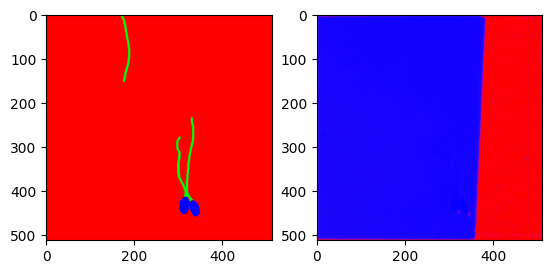

In [31]:
number = 1
plt.subplot(1,2,1)
plt.imshow(true[number])
plt.subplot(1,2,2)
plt.imshow(pred[number])

In [15]:
from sklearn.metrics import jaccard_score

# Przygotuj listy do przechowywania wszystkich prawdziwych i przewidywanych identyfikatorów klas
all_true_class_ids = []
all_pred_class_ids = []

# Przejdź przez wszystkie obrazy w zestawie danych
for true, pred in zip(true, pred):
    # Przekształć maski z formatu one-hot do formatu identyfikatorów klas
    true_class_id = np.argmax(true, axis=0)
    pred_class_id = np.argmax(pred, axis=0)

    # Dodaj identyfikatory klas do list
    all_true_class_ids.append(true_class_id.flatten())
    all_pred_class_ids.append(pred_class_id.flatten())

# Połącz wszystkie identyfikatory klas w jedną listę
all_true_class_ids = np.concatenate(all_true_class_ids)
all_pred_class_ids = np.concatenate(all_pred_class_ids)

# Oblicz jaccard_score dla każdej klasy
IoU_per_class = jaccard_score(all_true_class_ids, all_pred_class_ids, average=None)

for i, IoU in enumerate(IoU_per_class):
    print(f'Jaccard score for class {i}: {IoU}')



Jaccard score for class 0: 0.9938690276157031
Jaccard score for class 1: 0.3146592674136293
Jaccard score for class 2: 0.5552010118867952


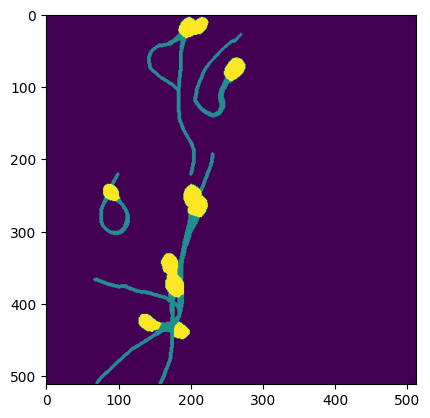

In [4]:
mask_to_display = true_masks[0]

# Przekształć maskę z formatu one-hot do formatu identyfikatorów klas
mask_to_display = np.argmax(mask_to_display, axis=0)

plt.imshow(mask_to_display)
plt.show()

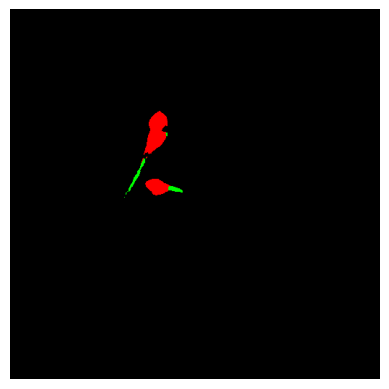

In [17]:
mask_to_display = predicted_masks[1]

# Przekształć maskę z formatu one-hot do formatu identyfikatorów klas
mask_to_display = np.argmax(mask_to_display, axis=0)

# Utwórz obraz RGB z maski
mask_rgb = np.zeros((mask_to_display.shape[0], mask_to_display.shape[1], 3), dtype=np.uint8)
for i, color in enumerate(colors):
    mask_rgb[mask_to_display == i] = color

plt.imshow(mask_rgb)
plt.axis('off')
plt.show()



2023-12-15 14:28:29.399976: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-15 14:28:29.419609: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 14:28:29.419629: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 14:28:29.419646: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 14:28:29.423636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: A

/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/train
/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Dataset/SegSperm/test_small
GPU dostępne: NVIDIA GeForce RTX 3090
EPOCH 1:
  batch 10 loss: 1.094739282131195


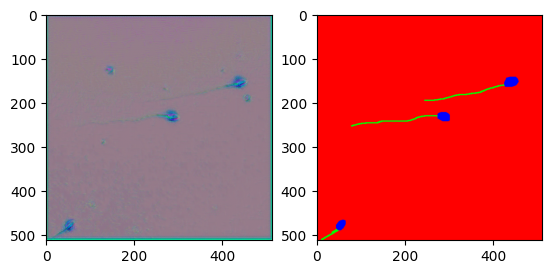

  batch 20 loss: 1.0320895791053772


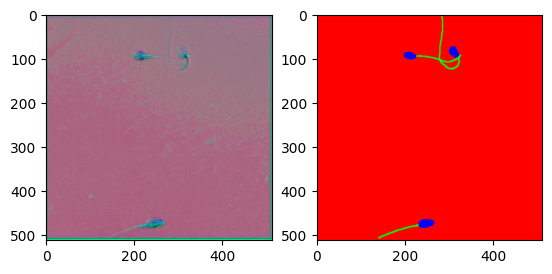

  batch 30 loss: 1.0060105443000793


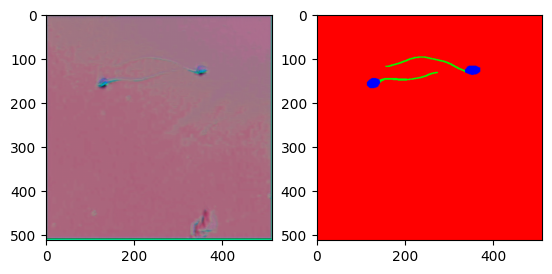

  batch 40 loss: 0.9868579983711243


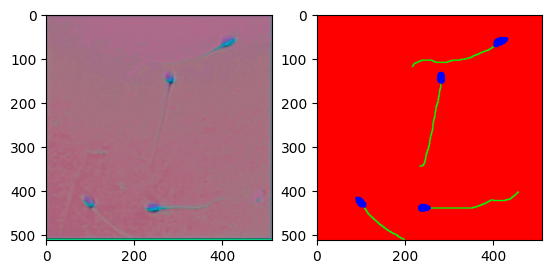

  batch 50 loss: 0.9776516795158386


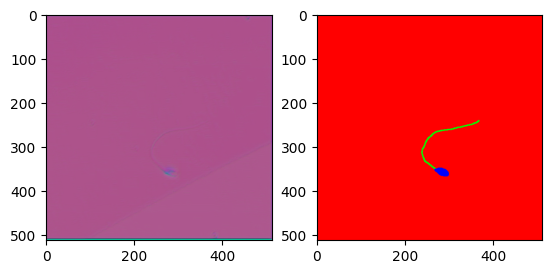

  batch 60 loss: 0.9655916810035705


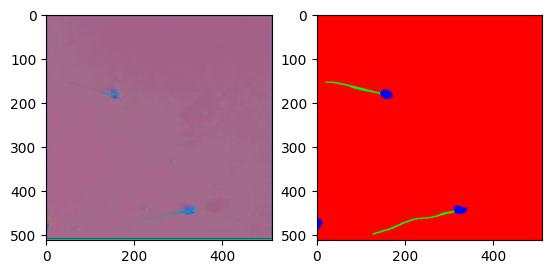

  batch 70 loss: 0.95582874417305


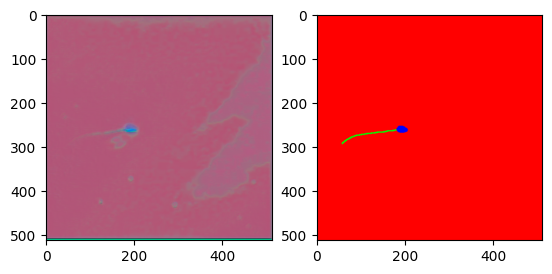

  batch 72 loss: 0.9493008553981781


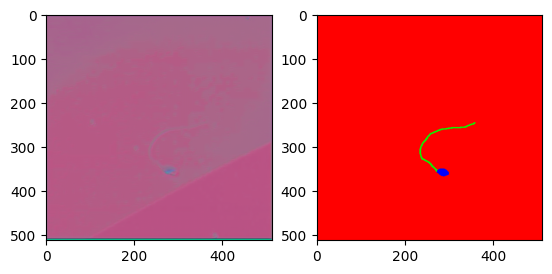

LOSS train 0.9493008553981781 valid 0.9760295152664185
IOU valid 0.6912012572926103


/home/cal314-1/miniconda3/envs/marcin/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


EPOCH 2:
  batch 10 loss: 0.9444796085357666


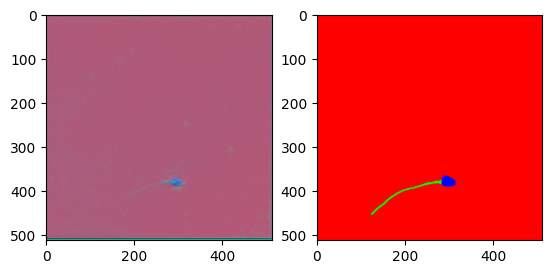

  batch 20 loss: 0.9371530532836914


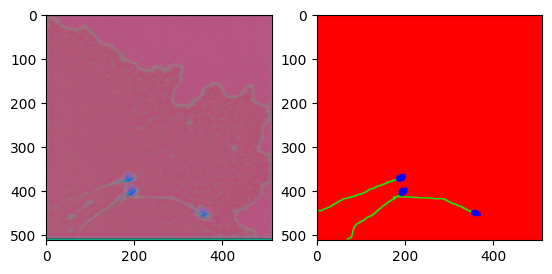

  batch 30 loss: 0.9297960937023163


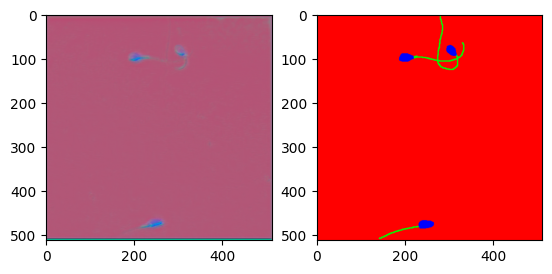

  batch 40 loss: 0.9216987371444703


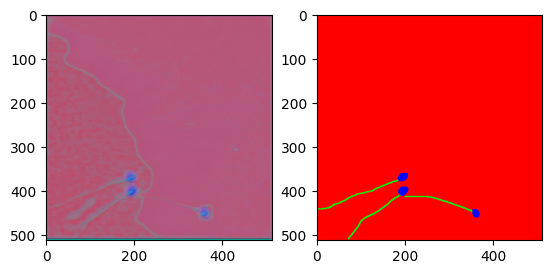

  batch 50 loss: 0.9136406302452087


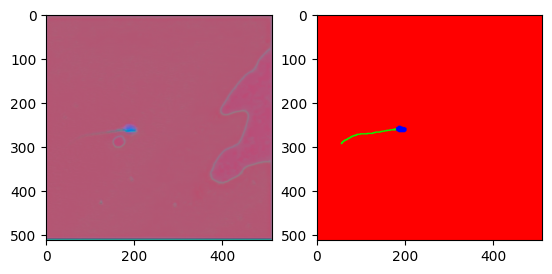

  batch 60 loss: 0.9067982733249664


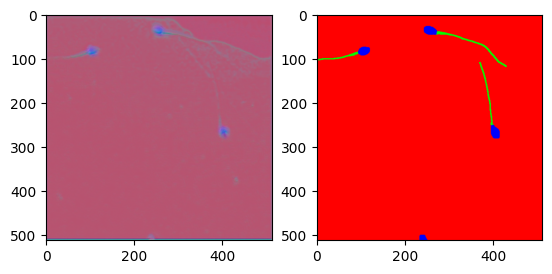

  batch 70 loss: 0.9024253129959107


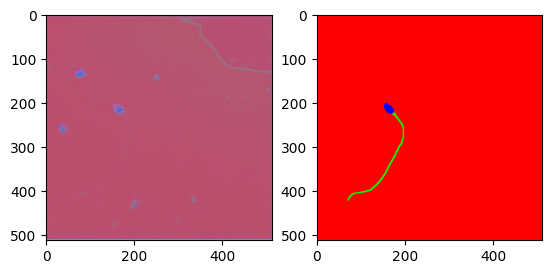

  batch 72 loss: 0.8962452113628387


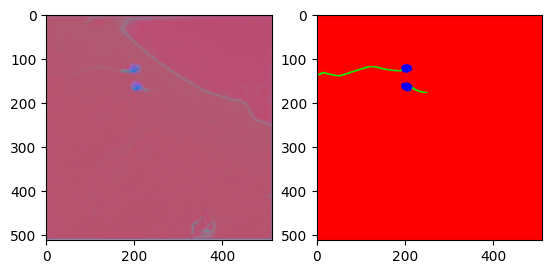

LOSS train 0.8962452113628387 valid 0.8910506367683411
IOU valid 0.6611430944306547
EPOCH 3:
  batch 10 loss: 0.8921453773975372


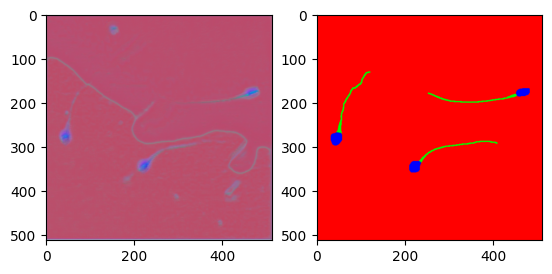

  batch 20 loss: 0.885185432434082


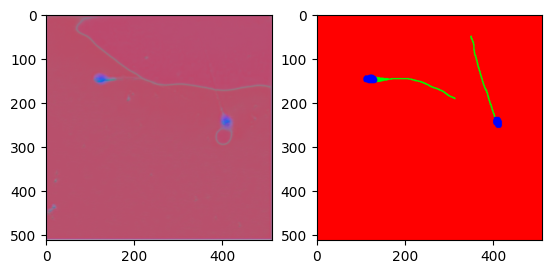

  batch 30 loss: 0.8794195294380188


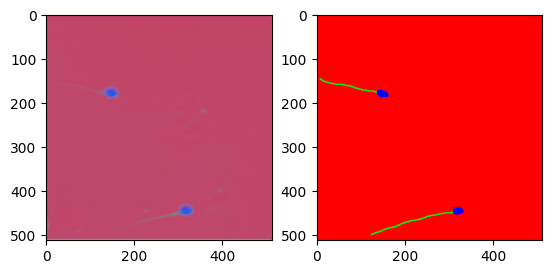

  batch 40 loss: 0.8728802502155304


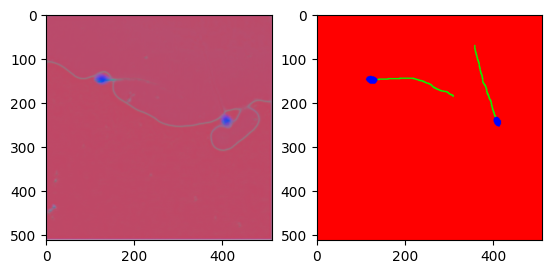

  batch 50 loss: 0.8668274879455566


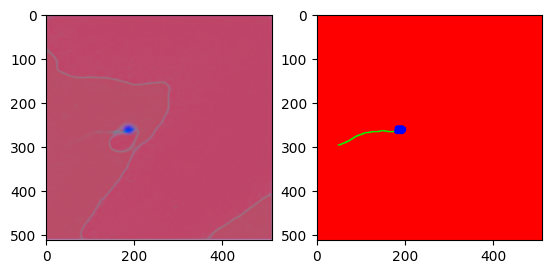

  batch 60 loss: 0.8603831350803375


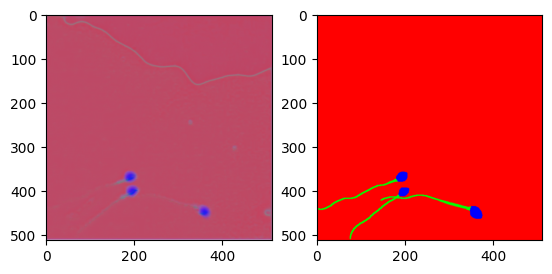

  batch 70 loss: 0.8555482864379883


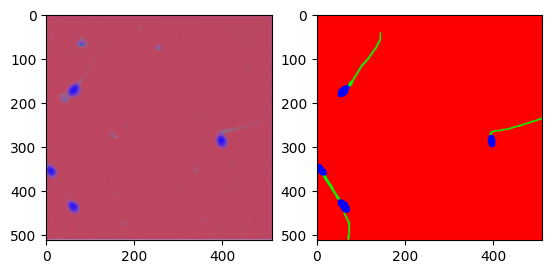

  batch 72 loss: 0.8520023822784424


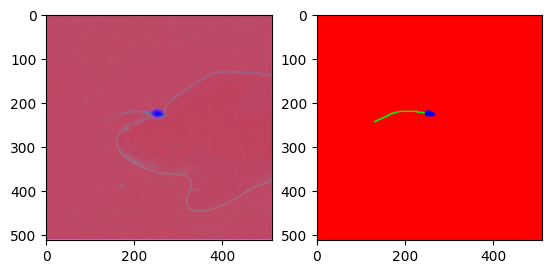

LOSS train 0.8520023822784424 valid 0.8594166040420532
IOU valid 0.6583304010532446
EPOCH 4:
  batch 10 loss: 0.848158860206604


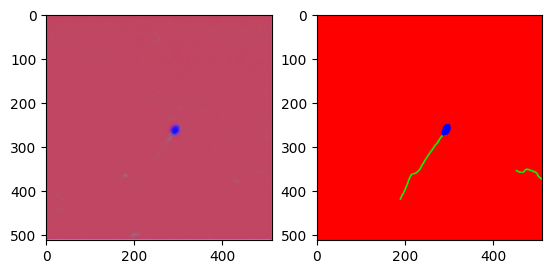

  batch 20 loss: 0.8426324546337127


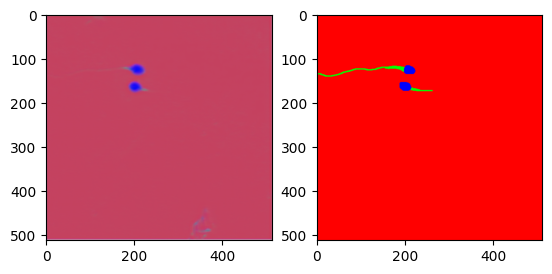

  batch 30 loss: 0.8374387383460998


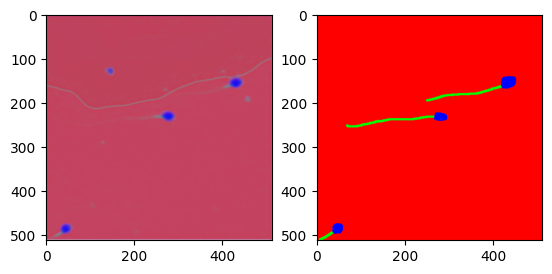

  batch 40 loss: 0.8325458824634552


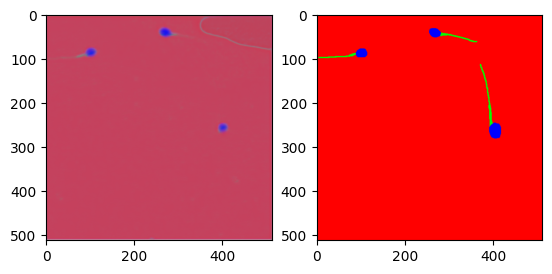

  batch 50 loss: 0.8269013047218323


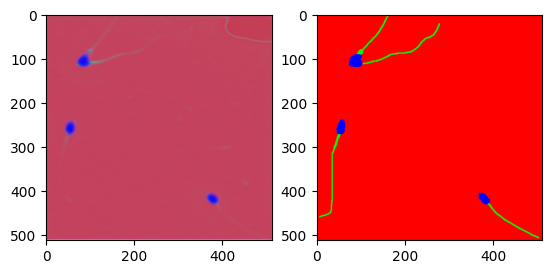

  batch 60 loss: 0.8223305642604828


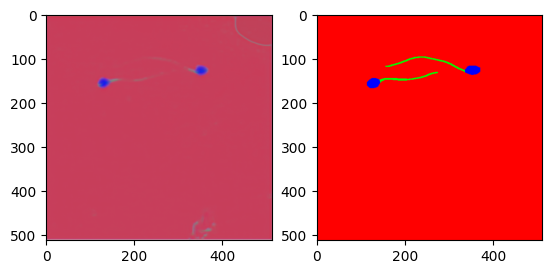

  batch 70 loss: 0.8165151238441467


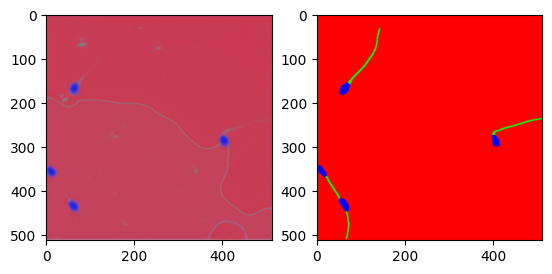

  batch 72 loss: 0.8138740062713623


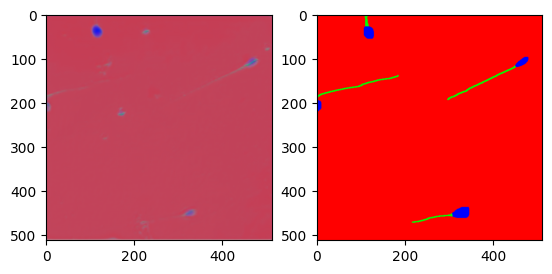

LOSS train 0.8138740062713623 valid 0.8045492172241211
IOU valid 0.6577394369953072
EPOCH 5:


KeyboardInterrupt: 

In [3]:
from models.Unet import UNet
from dataset.data import BatchMaker
from utils.metrics import SegmentationMetrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.tensorboard import SummaryWriter
import datetime
import yaml
import matplotlib.pyplot as plt
import kornia as K
import numpy as np


timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
#writer = SummaryWriter('runs/noisy_labels_trainer_{}'.format(timestamp))
writer = SummaryWriter('test_{}'.format(timestamp))
epoch_number = 0
num_classes = 3
EPOCHS = 100
BATCH = 6
learning_rate = 0.0001
best_viou = 1_000_000.
#path_to_config = '/media/marcin/Dysk lokalny/Programowanie/Python/Magisterka/Praca Dyplomowa/noisy_labels/Kod/config/config.yaml'
path_to_config = '/media/cal314-1/9E044F59044F3415/Marcin/noisy_labels/Kod/config/config_lab.yaml'
#path_to_config = '/home/nitro/Studia/Praca Dyplomowa/noisy_labels/Kod/config/config_laptop.yaml'
with open(path_to_config, 'r') as config_file:
    config = yaml.safe_load(config_file)


batch_maker = BatchMaker(config_path=path_to_config, batch_size=BATCH,mode ='train',segment = 'mixed',annotator= 2)
train_loader = batch_maker.train_loader
val_loader = batch_maker.val_loader


class MyAugmentation(nn.Module):
    def __init__(self):
        super().__init__()
        # we define and cache our operators as class members
        self.k1 = K.augmentation.ColorJitter(0.15, 0.25, 0.25, 0.25)
        self.k2 = K.augmentation.RandomAffine([-45.0, 45.0], [0.0, 0.15], [0.5, 1.5], [0.0, 0.15])

    def forward(self, img: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        # 1. apply color only in image
        # 2. apply geometric tranform
        img_out = self.k2(self.k1(img))

        # 3. infer geometry params to mask
        # TODO: this will change in future so that no need to infer params
        mask_out = self.k2(mask, self.k2._params)

        return img_out, mask_out



def train_one_epoch(epoch_index, tb_writer,augementation, T_aug = False,div =0):
    running_loss = 0.
    last_loss = 0.
    batches = len(train_loader)

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for batch_idx, (inputs, labels,ids) in enumerate(train_loader):
        # Every data instance is an input + label pair

        div += 1
        if T_aug == True:
            for i in range(inputs.shape[0]):
                inputs[i], labels[i] = augementation(inputs[i], labels[i])


        inputs = inputs.to(device)
        labels = labels.to(device)
        ids = ids.to(device)


        #fig, ax = plt.subplots(1, 6, figsize=(20, 10))
        #for i in range(inputs.shape[0]):
            #ax[i].imshow(labels[i].cpu().numpy().transpose(1,2,0))
            #ax[i].contour(labels[i].cpu().numpy().transpose(1,2,0).squeeze(), colors='k', levels=[0.5])
        #plt.show()

        # Zero your gradients for every batch
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)


        #print('Output = '+str(outputs.shape))
        #print('Labels = ' + str(ids.unique()))
        #print('Labels_shape = ' + str(ids.shape))
        # Compute the loss and its gradients
        loss = loss_fn(outputs, ids)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
     

        # Gather data and report
        running_loss += loss.item()
        if batch_idx % batches == batches - 1 or (batch_idx + 1) % 10 == 0:
            last_loss = running_loss / div # loss per batch
            print('  batch {} loss: {}'.format(batch_idx + 1, last_loss))
            #tb_x = epoch_index * len(train_loader) + batch_idx + 1
            #tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            plt.subplot(1,2,1)
            plt.imshow(outputs[0].detach().cpu().numpy().transpose(1,2,0))
            plt.subplot(1,2,2)
            plt.imshow(labels[0].detach().cpu().numpy().transpose(1,2,0))
            plt.pause(0.05)
            div = 0

    return last_loss


if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)  
    print("GPU dostępne:", gpu_name ) 
    device = torch.device("cuda")
else:
    raise Exception("Brak dostępnej karty GPU.")


model = UNet(3,num_classes)
model.to(device)

# Binary semantic segmentation problem
#loss_fn = nn.BCELoss()
# Multi-class semantic segmentation problem
# Assume `num_classes` is the number of classes
weights = torch.ones(num_classes)

# Set a higher weight for the second class
# weights[0] = 0.1
# weights[1] = 0.7
# weights[2] = 0.4

# If you're using a GPU, move the weights tensor to the same device as your model
weights = weights.to(device)

loss_fn = nn.CrossEntropyLoss(weight=weights)

aug = MyAugmentation()

# Definicja optymalizatora (np. Adam)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)


for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer,aug,T_aug = False)

    running_vloss = 0.0
    running_viou = 0.0
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for batch_idx, (vinputs, vlabels,vids) in enumerate(val_loader):
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            vids = vids.to(device)
            voutputs = model(vinputs)
            preds = torch.argmax(voutputs, dim=1)  # assuming a classification task
            metrics = SegmentationMetrics(num_classes)
            preds1 = preds.cpu().numpy()
            vids1 = vids.cpu().numpy()
            metrics.update_confusion_matrix(vids1, preds1)
            mean_iou = metrics.mean_iou()
            vloss = loss_fn(voutputs, vids)
            running_vloss += vloss
            viou = 1 - mean_iou
            running_viou += viou


    avg_vloss = running_vloss / (batch_idx + 1)
    avg_viou = running_viou / (batch_idx + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('IOU valid {}'.format(avg_viou))

    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    
    writer.add_scalar('Validation IOU', avg_viou, epoch_number + 1)
    
    for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
            writer.add_scalar('Learning Rate', current_lr, epoch * len(train_loader) + batch_idx)

    writer.flush()


    scheduler.step(avg_viou)

    # Track best performance, and save the model's state
    if avg_viou < best_viou:
        best_viou = avg_viou
        model_path = config['save_model_path'] + '/mixedGT1_best_model_test'
        torch.save(model.state_dict(), model_path)
    if epoch_number == EPOCHS - 1:
        model_path = config['save_model_path'] + '/mixedGT1_last_model_test'
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

In [29]:
import numpy as np

class SegmentationMetrics:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.confusion_matrix = np.zeros((num_classes, num_classes))

    def calculate_iou(self,prediction, ground_truth):
        iou_scores = np.zeros(self.num_classes)
        
        for cls in range(self.num_classes):
            true_positive = np.sum((prediction == cls) & (ground_truth == cls))
            false_positive = np.sum((prediction == cls) & (ground_truth != cls))
            false_negative = np.sum((prediction != cls) & (ground_truth == cls))

            union = true_positive + false_positive + false_negative

            iou = true_positive / union if union != 0 else 0
            iou_scores[cls] = iou

        return iou_scores

In [45]:
from sklearn.metrics import (
    jaccard_score,
    average_precision_score
)

num_classes = 3  # Przykładowa liczba klas
metrics = SegmentationMetrics(num_classes)

preds1 = preds.cpu().numpy()
vids1 = vids.cpu().numpy()


In [41]:
iou_scores = metrics.calculate_iou(preds1[0],vids1[0])
print("IoU dla każdej klasy:", iou_scores)
print("Średni IoU:", np.mean(iou_scores))

IoU dla każdej klasy: [0.98093225 0.         0.        ]
Średni IoU: 0.32697741729551827


In [53]:
all_pred_class_ids = []
all_true_class_ids = []
for true, pred in zip(vids1, preds1):
    # Przekształć maski z formatu one-hot do formatu identyfikatorów klas
    true_class_id = true
    pred_class_id = pred
    # Dodaj identyfikatory klas do list
    all_true_class_ids.append(true_class_id.flatten())
    all_pred_class_ids.append(pred_class_id.flatten())

# Połącz wszystkie identyfikatory klas w jedną listę
all_true_class_ids = np.concatenate(all_true_class_ids)
all_pred_class_ids = np.concatenate(all_pred_class_ids)

IoU_per_class = jaccard_score(all_true_class_ids, all_pred_class_ids, average=None)

for i, IoU in enumerate(IoU_per_class):
    print(f'Jaccard score for class {i}: {IoU}')


Jaccard score for class 0: 0.9852635321440397
Jaccard score for class 1: 0.0
Jaccard score for class 2: 0.0
